<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2205222%2Fbca114f2e4f6b9b46f2cc76527d7401e%2FImage_header.png?generation=1593773828621598&amp;alt=media" alt="">


# Movie Recommendation Challenge

###  1. [Overview](#Overview) 
- #### [Data](#The-Data)

###  2. [EDA](#Exploring-our-data)
###  3. [Machine Learning](#Building-the-model)
- #### Content based filtering
- #### Collaborative filtering

###  4. [Conclusion](#Conclusion)
- #### [Deployment and future work](#Deployed-App)




## Overview

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

## The Data
This dataset consists of several million 5-star ratings obtained from users of the online [MovieLens](https://movielens.org/) movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!



## Importing the dependancies

In [1]:
#===== The Usual Suspects =============
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#===== Machine Learning with Scikit Surprise ================
from surprise import SVD, accuracy, Dataset, NormalPredictor,SVDpp
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

### Loading csv files

In [45]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

## Exploring our data

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
# Merge the two datasets to gain more insights
df = pd.merge(movies,ratings, on='movieId').drop('timestamp', axis=1)

# Extract the year from each movie title to create a year release year column for each movie
df['year'] = df.title.str.extract("\((\d{4})\)", expand=True)
df.year = pd.to_datetime(df.year, format='%Y')

df.head()

,movieId,title,genres,userId,rating,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,1995-01-01
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,1995-01-01
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1995-01-01
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,1995-01-01
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,1995-01-01


In [6]:
df.loc[df.year.isnull()]

,movieId,title,genres,userId,rating,year
99426,143410,Hyena Road,(no genres listed),624,2.0,NaT
99488,151307,The Lovers and the Despot,(no genres listed),547,4.5,NaT


## Explore the data with some plots

Text(0, 0.5, 'Number of movies released')

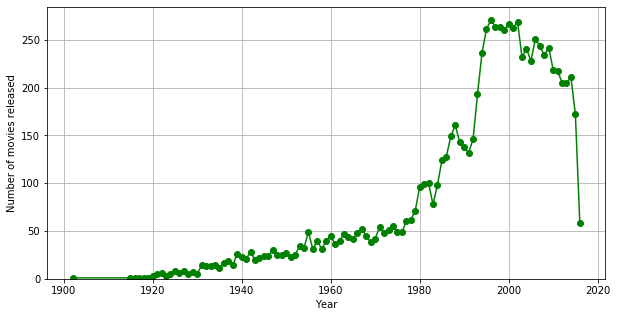

In [11]:
# Plot the number of movies released each year

movies_per_year = df[['movieId', 'year']].groupby('year')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(movies_per_year.year.first(), movies_per_year.movieId.nunique(), "g-o")
ax.grid(None)
ax.set_ylim(0,)
ax.set_xlabel('Year')
ax.set_ylabel('Number of movies released')

#### Insight 1

We see a sharp increase in the number of movies released between 1980 and 2000, and a sharp drop in movie production in 2009.

In [23]:
# Create a new dataframe with avarage rating and the number of rating for each movie

rating_df = pd.DataFrame(df.groupby('title')['rating'].mean())
rating_df['num_ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
rating_df.head()

,rating,num_ratings
title,,
"""Great Performances"" Cats (1998)",1.750000,2
$9.99 (2008),3.833333,3
'Hellboy': The Seeds of Creation (2004),2.000000,1
'Neath the Arizona Skies (1934),0.500000,1
'Round Midnight (1986),2.250000,2


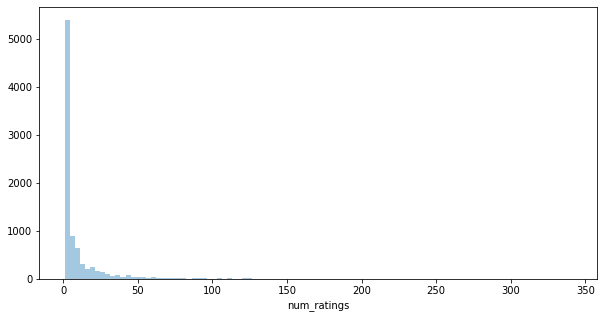

In [33]:
_ = plt.figure(figsize=(10,5))
_ = sns.distplot(rating_df.num_ratings,bins=100, kde=False)

#### Insight 2

Most movies have zero or one rating. This can be attributed to the unavailability of movie rating systems in the 1900s to early 90s, and that most people only rate the big hit movies. This could potentially affect the results of a collaborative filtering algorithm since it maps user ratings to items.

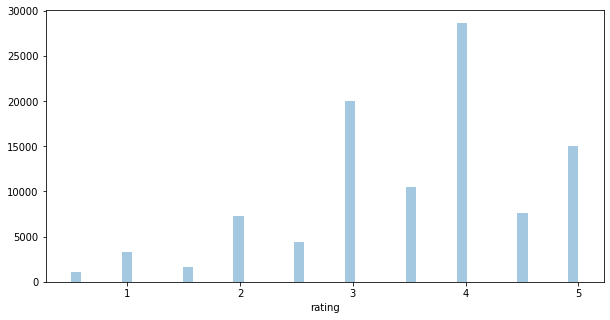

In [35]:
# Visual distribution of the average ratings

_ = plt.figure(figsize=(10,5))
_ = sns.distplot(df.rating, kde=False)


#### Insight 3

Movie ratings seem to be normally distributed.

<Figure size 720x504 with 0 Axes>

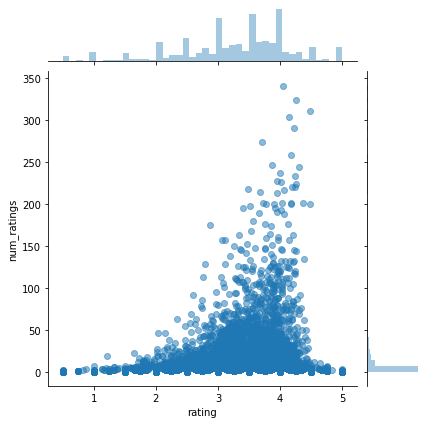

In [40]:
# Plot the relationship between average rating and number of ratings

_ = plt.figure(figsize=(10,7))
_ = sns.jointplot(x='rating',y='num_ratings',data=rating_df,alpha=0.5)


#### Insight 4

Looks like the more ratings a movie has, the higher the ratings for that movie.

## Building the model

In [47]:
print('Length of Movies dataset:', movies.shape[0],'rows')
print('Length of Ratings dataset:', ratings.shape[0],'rows')

Length of Movies dataset: 62423 rows
Length of Ratings dataset: 100004 rows


In [46]:
ratings = ratings.drop('timestamp',axis=1)

In [48]:
# Set the reader variable

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings,reader)

# Instantiate the model
SVDpp_model = SVDpp()


# Train Test Split method
X_train, X_test = train_test_split(data,test_size=0.2)

In [49]:
# Fit the model to our data

SVDpp_model.fit(X_train)

In [50]:
# Predict 

predictions = SVDpp_model.test(X_test)

In [51]:
# Check the accuracy of our model

accuracy.rmse(predictions)

RMSE: 0.8817


0.8816513512369597

## Conclusion

The model chosen for this task is the Singular Value Decomposition(`SVDpp`). This model performs probabilistic matrix factorization which is suitable for our Collaborative filtering task.
  

## Deployed App


[Link to the deployed streamlit app](###)

In [53]:
# Prepare Kaggle submission

test = pd.read_csv('test.csv')

# Make predictions on test data
pred_list = []

for _,row in test.iterrows():
    x = (SVDpp_model.predict(row.userId, row.movieId))
    pred = x[3]
    pred_list.append(pred)

In [103]:
# Convert values to strings

test['userId'] = test['userId'].astype(str)
test['movieId'] = test['movieId'].astype(str)

,userId,movieId
0,1,2011
1,1,4144


In [123]:
# Create submission column

test['Id'] = test['userId'] +'_'+test['movieId']

In [125]:
submission_df = pd.DataFrame({'Id':test['Id'],
                              'rating':pred_list})

In [ ]:
import pickle

model_save_path = 'SVDpp_model.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(SVDpp_model, file)


In [130]:
submission_df.head()

,Id,rating
0,1_2011,2.777108
1,1_4144,2.855609
2,1_5767,2.639799
3,1_6711,3.047753
4,1_7318,2.458937


In [128]:
submission_df.to_csv('k_sub.csv', index=False)